# Water quality
## Setup software libraries

In [1]:
# Import and initialize the Earth Engine library.
import ee
ee.Initialize()
ee.__version__

'0.1.202'

In [2]:
# Folium setup.
import folium
print(folium.__version__)

0.8.3


In [3]:
# Skydipper library.
import Skydipper
print(Skydipper.__version__)

0.1.7


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import functools
import json
import uuid
import os
from pprint import pprint
import env
import time

In [5]:
import ee_collection_specifics

## Composite image
**Variables**

In [6]:
collection = 'Lake-Water-Quality-100m'
init_date = '2019-01-21'
end_date = '2019-01-31'

In [7]:
# Define the URL format used for Earth Engine generated map tiles.
EE_TILES = 'https://earthengine.googleapis.com/map/{mapid}/{{z}}/{{x}}/{{y}}?token={token}'

composite = ee_collection_specifics.Composite(collection)(init_date, end_date)
mapid = composite.getMapId(ee_collection_specifics.vizz_params_rgb(collection))

tiles_url = EE_TILES.format(**mapid)

map = folium.Map(location=[39.31, 0.302])
folium.TileLayer(
tiles=tiles_url,
attr='Google Earth Engine',
overlay=True,
name=str(ee_collection_specifics.ee_bands_rgb(collection))).add_to(map)
    
map.add_child(folium.LayerControl())
map

***
## Geostore

We select the areas from which we will export the training data.

**Variables**

In [8]:
def polygons_to_multipoligon(polygons):
    multipoligon = []
    MultiPoligon = {}
    for polygon in polygons.get('features'):
        multipoligon.append(polygon.get('geometry').get('coordinates'))
        
    MultiPoligon = {
        "type": "FeatureCollection",
        "features": [
            {
                "type": "Feature",
                "properties": {},
                "geometry": {
                    "type": "MultiPolygon",
                    "coordinates":  multipoligon
                }
            }
        ]
    }
    
    return MultiPoligon

In [9]:
#trainPolygons = {"type":"FeatureCollection","features":[{"type":"Feature","properties":{},"geometry":{"type":"Polygon","coordinates":[[[-0.45043945312499994,39.142842478062505],[0.06042480468749999,39.142842478062505],[0.06042480468749999,39.55064761909318],[-0.45043945312499994,39.55064761909318],[-0.45043945312499994,39.142842478062505]]]}},{"type":"Feature","properties":{},"geometry":{"type":"Polygon","coordinates":[[[-0.2911376953125,38.659777730712534],[0.2581787109375,38.659777730712534],[0.2581787109375,39.10022600175347],[-0.2911376953125,39.10022600175347],[-0.2911376953125,38.659777730712534]]]}},{"type":"Feature","properties":{},"geometry":{"type":"Polygon","coordinates":[[[-0.3350830078125,39.56758783088905],[0.22521972656249997,39.56758783088905],[0.22521972656249997,39.757879992021756],[-0.3350830078125,39.757879992021756],[-0.3350830078125,39.56758783088905]]]}},{"type":"Feature","properties":{},"geometry":{"type":"Polygon","coordinates":[[[0.07965087890625,39.21310328979648],[0.23345947265625,39.21310328979648],[0.23345947265625,39.54852980171147],[0.07965087890625,39.54852980171147],[0.07965087890625,39.21310328979648]]]}},{"type":"Feature","properties":{},"geometry":{"type":"Polygon","coordinates":[[[-1.0931396484375,35.7286770448517],[-0.736083984375,35.7286770448517],[-0.736083984375,35.94243575255426],[-1.0931396484375,35.94243575255426],[-1.0931396484375,35.7286770448517]]]}},{"type":"Feature","properties":{},"geometry":{"type":"Polygon","coordinates":[[[-1.7303466796874998,35.16931803601131],[-1.4666748046875,35.16931803601131],[-1.4666748046875,35.74205383068037],[-1.7303466796874998,35.74205383068037],[-1.7303466796874998,35.16931803601131]]]}},{"type":"Feature","properties":{},"geometry":{"type":"Polygon","coordinates":[[[-1.42822265625,35.285984736065764],[-1.131591796875,35.285984736065764],[-1.131591796875,35.782170703266075],[-1.42822265625,35.782170703266075],[-1.42822265625,35.285984736065764]]]}},{"type":"Feature","properties":{},"geometry":{"type":"Polygon","coordinates":[[[-1.8127441406249998,35.831174956246535],[-1.219482421875,35.831174956246535],[-1.219482421875,36.04465753921525],[-1.8127441406249998,36.04465753921525],[-1.8127441406249998,35.831174956246535]]]}}]}
trainPolygons = {"type":"FeatureCollection","features":[{"type":"Feature","properties":{},"geometry":{"type":"Polygon","coordinates":[[[-0.406494140625,38.64476310916202],[0.27740478515625,38.64476310916202],[0.27740478515625,39.74521015328692],[-0.406494140625,39.74521015328692],[-0.406494140625,38.64476310916202]]]}},{"type":"Feature","properties":{},"geometry":{"type":"Polygon","coordinates":[[[-1.70013427734375,35.15135442846945],[-0.703125,35.15135442846945],[-0.703125,35.94688293218141],[-1.70013427734375,35.94688293218141],[-1.70013427734375,35.15135442846945]]]}}]}
trainPolys = polygons_to_multipoligon(trainPolygons)

evalPolys = None

In [10]:
nTrain = len(trainPolys.get('features')[0].get('geometry').get('coordinates'))
print('Number of training polygons:',  nTrain)

if evalPolys:
    nEval = len(evalPolys.get('features')[0].get('geometry').get('coordinates'))
    print('Number of training polygons:',  nEval)

Number of training polygons: 2


**Display Polygons**

In [11]:
# Define the URL format used for Earth Engine generated map tiles.
EE_TILES = 'https://earthengine.googleapis.com/map/{mapid}/{{z}}/{{x}}/{{y}}?token={token}'

composite = ee_collection_specifics.Composite(collection)(init_date, end_date)
mapid = composite.getMapId(ee_collection_specifics.vizz_params_rgb(collection))

tiles_url = EE_TILES.format(**mapid)

map = folium.Map(location=[39.31, 0.302], zoom_start=6)
folium.TileLayer(
tiles=tiles_url,
attr='Google Earth Engine',
overlay=True,
name=str(ee_collection_specifics.ee_bands_rgb(collection))).add_to(map)
    

#  Convert the GeoJSONs to feature collections
trainFeatures = ee.FeatureCollection(trainPolys.get('features'))
if evalPolys:
    evalFeatures = ee.FeatureCollection(evalPolys.get('features'))
    
polyImage = ee.Image(0).byte().paint(trainFeatures, 1)
if evalPolys:
    polyImage = ee.Image(0).byte().paint(trainFeatures, 1).paint(evalFeatures, 2)
polyImage = polyImage.updateMask(polyImage)

mapid = polyImage.getMapId({'min': 1, 'max': 2, 'palette': ['red', 'blue']})
folium.TileLayer(
    tiles=EE_TILES.format(**mapid),
    attr='Google Earth Engine',
    overlay=True,
    name='training polygons',
  ).add_to(map)

map.add_child(folium.LayerControl())
map

***
## Data pre-processing

We normalize the composite images to have values from 0 to 1.

**Variables**

In [12]:
input_dataset = 'Sentinel-2-Top-of-Atmosphere-Reflectance'
output_dataset = 'Lake-Water-Quality-100m'
init_date = '2019-01-21'
end_date = '2019-01-31'
scale = 100 #scale in meters
collections = [input_dataset, output_dataset]

**Normalize images**

In [13]:
def min_max_values(image, collection, scale, polygons=None):
    
    normThreshold = ee_collection_specifics.ee_bands_normThreshold(collection)
    
    num = 2
    lon = np.linspace(-180, 180, num)
    lat = np.linspace(-90, 90, num)
    
    features = []
    for i in range(len(lon)-1):
        for j in range(len(lat)-1):
            features.append(ee.Feature(ee.Geometry.Rectangle(lon[i], lat[j], lon[i+1], lat[j+1])))
            
    if not polygons:
        polygons = ee.FeatureCollection(features)
    
    regReducer = {
        'geometry': polygons,
        'reducer': ee.Reducer.minMax(),
        'maxPixels': 1e10,
        'bestEffort': True,
        'scale':scale,
        'tileScale': 10
        
    }
    
    values = image.reduceRegion(**regReducer).getInfo()
    print(values)
    
    # Avoid outliers by taking into account only the normThreshold% of the data points.
    regReducer = {
        'geometry': polygons, 
        'reducer': ee.Reducer.histogram(),
        'maxPixels': 1e10,
        'bestEffort': True,
        'scale':scale,
        'tileScale': 10
        
    }
    
    hist = image.reduceRegion(**regReducer).getInfo()

    for band in list(normThreshold.keys()):
        if normThreshold[band] != 100:
            count = np.array(hist.get(band).get('histogram'))
            x = np.array(hist.get(band).get('bucketMeans'))
        
            cumulative_per = np.cumsum(count/count.sum()*100)
        
            values[band+'_max'] = x[np.where(cumulative_per < normThreshold[band])][-1]
        
    return values

def normalize_ee_images(image, collection, values):
    
    Bands = ee_collection_specifics.ee_bands(collection)
       
    # Normalize [0, 1] ee images
    for i, band in enumerate(Bands):
        if i == 0:
            image_new = image.select(band).clamp(values[band+'_min'], values[band+'_max'])\
                                .subtract(values[band+'_min'])\
                                .divide(values[band+'_max']-values[band+'_min'])
        else:
            image_new = image_new.addBands(image.select(band).clamp(values[band+'_min'], values[band+'_max'])\
                                    .subtract(values[band+'_min'])\
                                    .divide(values[band+'_max']-values[band+'_min']))
            
    return image_new

In [14]:
%%time

images = []
for collection in collections:
    # Create composite
    image = ee_collection_specifics.Composite(collection)(init_date, end_date)
    
    bands = ee_collection_specifics.ee_bands(collection)
    image = image.select(bands)
    
    #Create composite
    if ee_collection_specifics.normalize(collection):
        # Get min man values for each band
        values = min_max_values(image, collection, scale, polygons=trainFeatures)
        print(values)
    
        # Normalize images
        image = normalize_ee_images(image, collection, values)
    else:
        values = {}
        
    images.append(image)

{'B11_max': 10857.5, 'B11_min': 7.0, 'B12_max': 10691.0, 'B12_min': 1.0, 'B1_max': 6806.0, 'B1_min': 983.0, 'B2_max': 6406.0, 'B2_min': 685.0, 'B3_max': 6182.0, 'B3_min': 412.0, 'B4_max': 7485.5, 'B4_min': 229.0, 'B5_max': 8444.0, 'B5_min': 186.0, 'B6_max': 9923.0, 'B6_min': 153.0, 'B7_max': 11409.0, 'B7_min': 128.0, 'B8A_max': 12957.0, 'B8A_min': 84.0, 'B8_max': 7822.0, 'B8_min': 104.0, 'ndvi_max': 0.8359633027522936, 'ndvi_min': -0.6463519313304721, 'ndwi_max': 0.7134948096885814, 'ndwi_min': -0.8102189781021898}
{'B11_max': 10857.5, 'B11_min': 7.0, 'B12_max': 10691.0, 'B12_min': 1.0, 'B1_max': 1330.4577965925362, 'B1_min': 983.0, 'B2_max': 1039.5402534802868, 'B2_min': 685.0, 'B3_max': 879.6981149345532, 'B3_min': 412.0, 'B4_max': 751.6494664084341, 'B4_min': 229.0, 'B5_max': 1119.6073607546705, 'B5_min': 186.0, 'B6_max': 1823.92697289679, 'B6_min': 153.0, 'B7_max': 2079.9614737864276, 'B7_min': 128.0, 'B8A_max': 2207.831974029281, 'B8A_min': 84.0, 'B8_max': 2031.6418424876374, 'B8_

**Display composite**

In [69]:
# Define the URL format used for Earth Engine generated map tiles.
EE_TILES = 'https://earthengine.googleapis.com/map/{mapid}/{{z}}/{{x}}/{{y}}?token={token}'
map = folium.Map(location=[39.31, 0.302], zoom_start=6)
for n, collection in enumerate(collections):
    for params in ee_collection_specifics.vizz_params(collection):
        mapid = images[n].getMapId(params)
        folium.TileLayer(
        tiles=EE_TILES.format(**mapid),
        attr='Google Earth Engine',
        overlay=True,
        name=str(params['bands']),
      ).add_to(map)
        
#  Convert the GeoJSONs to feature collections
trainFeatures = ee.FeatureCollection(trainPolys.get('features'))
if evalPolys:
    evalFeatures = ee.FeatureCollection(evalPolys.get('features'))
    
polyImage = ee.Image(0).byte().paint(trainFeatures, 1)
if evalPolys:
    polyImage = ee.Image(0).byte().paint(trainFeatures, 1).paint(evalFeatures, 2)
polyImage = polyImage.updateMask(polyImage)

mapid = polyImage.getMapId({'min': 1, 'max': 2, 'palette': ['red', 'blue']})
folium.TileLayer(
    tiles=EE_TILES.format(**mapid),
    attr='Google Earth Engine',
    overlay=True,
    name='training polygons',
  ).add_to(map)

map.add_child(folium.LayerControl())
map

***
## Create TFRecords for training
### Export pixels
**Variables**

In [16]:
input_bands = ['B2','B3','B4','B5','ndvi','ndwi']
output_bands = ['turbidity_blended_mean']
bands = [input_bands, output_bands]

dataset_name = 'Sentinel2_WaterQuality'
base_names = ['training_pixels', 'eval_pixels']
bucket = env.bucket_name
folder = 'cnn-models/'+dataset_name+'/data'

**Select the bands**

In [17]:
# Select the bands we want
c = images[0].select(bands[0])\
.addBands(images[1].select(bands[1]))

pprint(c.getInfo())

{'bands': [{'crs': 'EPSG:4326',
            'crs_transform': [1.0, 0.0, 0.0, 0.0, 1.0, 0.0],
            'data_type': {'max': 1.0,
                          'min': 0.0,
                          'precision': 'double',
                          'type': 'PixelType'},
            'id': 'B2'},
           {'crs': 'EPSG:4326',
            'crs_transform': [1.0, 0.0, 0.0, 0.0, 1.0, 0.0],
            'data_type': {'max': 1.0,
                          'min': 0.0,
                          'precision': 'double',
                          'type': 'PixelType'},
            'id': 'B3'},
           {'crs': 'EPSG:4326',
            'crs_transform': [1.0, 0.0, 0.0, 0.0, 1.0, 0.0],
            'data_type': {'max': 1.0,
                          'min': 0.0,
                          'precision': 'double',
                          'type': 'PixelType'},
            'id': 'B4'},
           {'crs': 'EPSG:4326',
            'crs_transform': [1.0, 0.0, 0.0, 0.0, 1.0, 0.0],
            'data_type': {'max': 1

**Sample pixels**

In [18]:
sr = c.sample(region = trainFeatures, scale = scale, numPixels=20000, tileScale=4, seed=999)

# Add random column
sr = sr.randomColumn(seed=999)

# Partition the sample approximately 70-30.
train_dataset = sr.filter(ee.Filter.lt('random', 0.7))
eval_dataset = sr.filter(ee.Filter.gte('random', 0.7))

In [19]:
# Print the first couple points to verify.
pprint({'training': train_dataset.first().getInfo()})
pprint({'testing': eval_dataset.first().getInfo()})

{'training': {'geometry': None,
              'id': '6',
              'properties': {'B2': 0.8574484759229267,
                             'B3': 0.3634823288175723,
                             'B4': 0.12149634522036754,
                             'B5': 0.05248459048179679,
                             'ndvi': 0.18857628593212067,
                             'ndwi': 0.12332980645053383,
                             'random': 0.09306798233949642,
                             'turbidity_blended_mean': 0.24297301471233368},
              'type': 'Feature'}}
{'testing': {'geometry': None,
             'id': '10',
             'properties': {'B2': 0.801037391980629,
                            'B3': 0.31109811084092215,
                            'B4': 0.10618971905087242,
                            'B5': 0.043915677750074864,
                            'ndvi': 0.17896596086026012,
                            'ndwi': 0.119761173841839,
                            'random': 0.8190823

In [20]:
# Print the first couple points to verify.
from pprint import pprint
train_size=train_dataset.size().getInfo()
eval_size=eval_dataset.size().getInfo()

pprint({'training': train_size})
pprint({'testing': eval_size})

{'training': 8096}
{'testing': 3427}


**Export the training and validation data**

In [21]:
def export_TFRecords_pixels(datasets, base_names, bucket, folder, selectors):
    # Export all the training/evaluation data 
    
    filePaths = []
    for n, dataset in enumerate(datasets):
        
        filePaths.append(bucket+ '/' + folder + '/' + base_names[n])
        
        # Create the tasks.
        task = ee.batch.Export.table.toCloudStorage(
          collection = dataset,
          description = 'Export '+base_names[n],
          fileNamePrefix = folder + '/' + base_names[n],
          bucket = bucket,
          fileFormat = 'TFRecord',
          selectors = selectors)
        
        task.start()
            
    return filePaths

In [ ]:
datasets = [train_dataset, eval_dataset]
selectors = input_bands + output_bands

# Export training/evaluation data
filePaths = export_TFRecords_pixels(datasets, base_names, bucket, folder, selectors)

***
## Inspect data
### Inspect pixels
Load the data exported from Earth Engine into a tf.data.Dataset. 

**Helper functions**

In [180]:
# Tensorflow setup.
import tensorflow as tf

if tf.__version__ == '1.15.0':
    tf.enable_eager_execution()
print(tf.__version__)

1.15.0


In [184]:
def parse_function(proto):
    """The parsing function.
    Read a serialized example into the structure defined by FEATURES_DICT.
    Args:
      example_proto: a serialized Example.
    Returns: 
      A tuple of the predictors dictionary and the labels.
    """
    
    # Define your tfrecord 
    features = input_bands + output_bands
    
    # Specify the size and shape of patches expected by the model.
    columns = [
      tf.io.FixedLenFeature(shape=[1,1], dtype=tf.float32) for k in features
    ]
    
    features_dict = dict(zip(features, columns))
    
    # Load one example
    parsed_features = tf.io.parse_single_example(proto, features_dict)
    
    # Convert a dictionary of tensors to a tuple of (inputs, outputs)
    inputsList = [parsed_features.get(key) for key in features]
    stacked = tf.stack(inputsList, axis=0)
    
    # Convert the tensors into a stack in HWC shape
    stacked = tf.transpose(stacked, [1, 2, 0])
    
    return stacked[:,:,:len(input_bands)], stacked[:,:,len(input_bands):]

def get_dataset(glob, buffer_size, batch_size):
    """Get the dataset
    Returns: 
    A tf.data.Dataset of training data.
    """
    glob = tf.compat.v1.io.gfile.glob(glob)
    
    dataset = tf.data.TFRecordDataset(glob, compression_type='GZIP')
    dataset = dataset.map(parse_function, num_parallel_calls=5)
    
    dataset = dataset.shuffle(buffer_size).batch(batch_size).repeat()
    return dataset

**Variables**

In [185]:
buffer_size = 100
batch_size = 4

**Dataset**

In [186]:
glob = 'gs://' + bucket + '/' + folder + '/' + base_names[0] + '*'
dataset = get_dataset(glob, buffer_size, batch_size)
dataset

<DatasetV1Adapter shapes: ((?, 1, 1, 6), (?, 1, 1, 1)), types: (tf.float32, tf.float32)>

**Check the first record**

In [155]:
arr = iter(dataset.take(1)).next()
input_arr = arr[0].numpy()
print(input_arr.shape)
output_arr = arr[1].numpy()
print(output_arr.shape)

(4, 1, 1, 6)
(4, 1, 1, 1)


***
## Training the model locally
**Variables**

In [161]:
job_dir = 'gs://' + bucket + '/' + 'cnn-models/'+ dataset_name +'/trainer'
logs_dir = job_dir + '/logs'
model_dir = job_dir + '/model'
shuffle_size = 2000
batch_size = 4
epochs=50
train_size=train_size
eval_size=eval_size
output_activation=''

**Training/evaluation data**

The following is code to load training/evaluation data.

In [162]:
import tensorflow as tf

def parse_function(proto):
    """The parsing function.
    Read a serialized example into the structure defined by FEATURES_DICT.
    Args:
      example_proto: a serialized Example.
    Returns: 
      A tuple of the predictors dictionary and the labels.
    """
    
    # Define your tfrecord 
    features = input_bands + output_bands
    
    # Specify the size and shape of patches expected by the model.
    columns = [
      tf.io.FixedLenFeature(shape=[1,1], dtype=tf.float32) for k in features
    ]
    
    features_dict = dict(zip(features, columns))
    
    # Load one example
    parsed_features = tf.io.parse_single_example(proto, features_dict)
    
    # Convert a dictionary of tensors to a tuple of (inputs, outputs)
    inputsList = [parsed_features.get(key) for key in features]
    stacked = tf.stack(inputsList, axis=0)
    
    # Convert the tensors into a stack in HWC shape
    stacked = tf.transpose(stacked)
    
    return stacked[:,:,:len(input_bands)], stacked[:,:,len(input_bands):]

def get_dataset(glob):
    """Get the dataset
    Returns: 
    A tf.data.Dataset of training data.
    """
    glob = tf.compat.v1.io.gfile.glob(glob)
    
    dataset = tf.data.TFRecordDataset(glob, compression_type='GZIP')
    dataset = dataset.map(parse_function, num_parallel_calls=5)
    
    return dataset


def get_training_dataset():
    """Get the preprocessed training dataset
    Returns: 
    A tf.data.Dataset of training data.
    """
    glob = 'gs://' + bucket + '/' + folder + '/' + base_names[0] + '*'
    dataset = get_dataset(glob)
    dataset = dataset.shuffle(shuffle_size).batch(batch_size).repeat()
    return dataset

def get_evaluation_dataset():
    """Get the preprocessed evaluation dataset
    Returns: 
      A tf.data.Dataset of evaluation data.
    """
    glob = 'gs://' + bucket + '/' + folder + '/' + base_names[1] + '*'
    dataset = get_dataset(glob)
    dataset = dataset.batch(1).repeat()
    return dataset

**Model**

In [163]:
from tensorflow.python.keras import Model # Keras model module
from tensorflow.python.keras.layers import Input, Dense, Dropout, Activation 

def create_keras_model(inputShape, nClasses, output_activation='linear'):
    
    inputs = Input(shape=inputShape, name='vector')
 
    x = Dense(32, input_shape=inputShape, activation='relu')(inputs)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(nClasses)(x)
    
    outputs = Activation(output_activation, name= 'output')(x)
        
    model = Model(inputs=inputs, outputs=outputs, name='sequential')
        
    return model

**Training task**

The following will get the training and evaluation data, train the model and save it when it's done in a Cloud Storage bucket.

In [164]:
import tensorflow as tf
import time
import os
          
def train_and_evaluate():
    """Trains and evaluates the Keras model.

    Uses the Keras model defined in model.py and trains on data loaded and
    preprocessed in util.py. Saves the trained model in TensorFlow SavedModel
    format to the path defined in part by the --job-dir argument.
    """

    # Create the Keras Model
    if not output_activation:
        keras_model = create_keras_model(inputShape = (None, None, len(input_bands)), nClasses = len(output_bands))
    else:
        keras_model = create_keras_model(inputShape = (None, None, len(input_bands)), nClasses = len(output_bands), output_activation = output_activation)

    # Compile Keras model
    keras_model.compile(loss='mse', optimizer='adam', metrics=['mse'])


    # Pass a tfrecord
    training_dataset = get_training_dataset()
    evaluation_dataset = get_evaluation_dataset()
    
    # Setup TensorBoard callback.
    tensorboard_cb = tf.keras.callbacks.TensorBoard(logs_dir)

    # Train model
    keras_model.fit(
        x=training_dataset,
        steps_per_epoch=int(train_size / batch_size),
        epochs=epochs,
        validation_data=evaluation_dataset,
        validation_steps=int(eval_size / batch_size),
        verbose=1,
        callbacks=[tensorboard_cb])
    
    tf.keras.models.save_model(keras_model, filepath=os.path.join(model_dir, str(int(time.time()))), save_format="tf")
    
    return keras_model

In [165]:
model = train_and_evaluate()

Train for 2024 steps, validate for 856 steps
Epoch 1/50
2024/2024 [==============================] - 12s 6ms/step - loss: 81.5057 - mean_squared_error: 81.5359 - val_loss: 62.0767 - val_mean_squared_error: 62.0767
Epoch 2/50
2024/2024 [==============================] - 6s 3ms/step - loss: 74.9204 - mean_squared_error: 74.9481 - val_loss: 56.7340 - val_mean_squared_error: 56.7339
Epoch 3/50
2024/2024 [==============================] - 11s 6ms/step - loss: 75.3469 - mean_squared_error: 75.3743 - val_loss: 50.1078 - val_mean_squared_error: 50.1078
Epoch 4/50
2024/2024 [==============================] - 11s 6ms/step - loss: 59.7888 - mean_squared_error: 59.8110 - val_loss: 49.4314 - val_mean_squared_error: 49.4314
Epoch 5/50
2024/2024 [==============================] - 7s 3ms/step - loss: 66.3342 - mean_squared_error: 66.3587 - val_loss: 46.5587 - val_mean_squared_error: 46.5586
Epoch 6/50
2024/2024 [==============================] - 7s 4ms/step - loss: 60.5214 - mean_squared_error: 60.543

**Evaluate model**

In [166]:
evaluation_dataset = get_evaluation_dataset()
model.evaluate(evaluation_dataset, steps=int(eval_size / batch_size))

856/856 [==============================] - 1s 912us/step - loss: 2.3542 - mean_squared_error: 2.3542


[2.3541856843101154, 2.3541858]

### Read pretrained model

In [100]:
job_dir = 'gs://' + env.bucket_name + '/' + 'cnn-models/' + dataset_name + '/trainer'
model_dir = job_dir + '/model'
PROJECT_ID = env.project_id

In [101]:
# Pick the directory with the latest timestamp, in case you've trained multiple times
exported_model_dirs = ! gsutil ls {model_dir}
saved_model_path = exported_model_dirs[-1]

In [102]:
model = tf.keras.models.load_model(saved_model_path)

***
## Predict in Earth Engine

### Prepare the model for making predictions in Earth Engine

Before we can use the model in Earth Engine, it needs to be hosted by AI Platform.  But before we can host the model on AI Platform we need to *EEify* (a new word!) it.  The EEification process merely appends some extra operations to the input and outputs of the model in order to accomdate the interchange format between pixels from Earth Engine (float32) and inputs to AI Platform (base64).  (See [this doc](https://cloud.google.com/ml-engine/docs/online-predict#binary_data_in_prediction_input) for details.)  

**`earthengine model prepare`**

The EEification process is handled for you using the Earth Engine command `earthengine model prepare`.  To use that command, we need to specify the input and output model directories and the name of the input and output nodes in the TensorFlow computation graph.  We can do all that programmatically:

In [167]:
dataset_name = 'Sentinel2_WaterQuality'
job_dir = 'gs://' + env.bucket_name + '/' + 'cnn-models/' + dataset_name + '/trainer'
model_dir = job_dir + '/model'
PROJECT_ID = env.project_id

In [168]:
# Pick the directory with the latest timestamp, in case you've trained multiple times
exported_model_dirs = ! gsutil ls {model_dir}
saved_model_path = exported_model_dirs[-1]

folder_name = saved_model_path.split('/')[-2]

In [169]:
from tensorflow.python.tools import saved_model_utils

meta_graph_def = saved_model_utils.get_meta_graph_def(saved_model_path, 'serve')
inputs = meta_graph_def.signature_def['serving_default'].inputs
outputs = meta_graph_def.signature_def['serving_default'].outputs

# Just get the first thing(s) from the serving signature def.  i.e. this
# model only has a single input and a single output.
input_name = None
for k,v in inputs.items():
    input_name = v.name
    break

output_name = None
for k,v in outputs.items():
    output_name = v.name
    break

# Make a dictionary that maps Earth Engine outputs and inputs to 
# AI Platform inputs and outputs, respectively.
import json
input_dict = "'" + json.dumps({input_name: "array"}) + "'"
output_dict = "'" + json.dumps({output_name: "prediction"}) + "'"

# Put the EEified model next to the trained model directory.
EEIFIED_DIR = job_dir + '/eeified/' + folder_name

# You need to set the project before using the model prepare command.
!earthengine set_project {PROJECT_ID}
!earthengine model prepare --source_dir {saved_model_path} --dest_dir {EEIFIED_DIR} --input {input_dict} --output {output_dict}

Running command using Cloud API.  Set --no-use_cloud_api to go back to using the API

Successfully saved project id
Running command using Cloud API.  Set --no-use_cloud_api to go back to using the API

Success: model at 'gs://skydipper_materials/cnn-models/Sentinel2_WaterQuality/trainer/eeified/1580401312' is ready to be hosted in AI Platform.


**Deployed the model to AI Platform**

In [170]:
%%writefile config.yaml
autoScaling:
    minNodes: 10

Overwriting config.yaml


In [171]:
REGION = "us-central1"
MODEL_NAME = 'water_quality_test'
VERSION_NAME = 'v' + folder_name
print('Creating version: ' + VERSION_NAME)

!gcloud ai-platform models create {MODEL_NAME} 
!gcloud ai-platform versions create {VERSION_NAME} \
  --model {MODEL_NAME} \
  --origin {EEIFIED_DIR} \
  --runtime-version=1.14 \
  --framework "TENSORFLOW" \
  --python-version=3.5

Creating version: v1580401312
ERROR: (gcloud.ai-platform.models.create) Resource in project [skydipper-196010] is the subject of a conflict: Field: model.name Error: A model with the same name already exists.
- '@type': type.googleapis.com/google.rpc.BadRequest
  fieldViolations:
  - description: A model with the same name already exists.
    field: model.name
Creating version (this might take a few minutes)......done.                    


### Load the trained model and use it for prediction in Earth Engine
**Variables**

In [172]:
# polygon where we want to display de predictions
geometry = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              -2.63671875,
              34.56085936708384
            ],
            [
              -1.2084960937499998,
              34.56085936708384
            ],
            [
              -1.2084960937499998,
              36.146746777814364
            ],
            [
              -2.63671875,
              36.146746777814364
            ],
            [
              -2.63671875,
              34.56085936708384
            ]
          ]
        ]
      }
    }
  ]
}

**Input image**

Select bands and convert them into float

In [173]:
image = images[0].select(bands[0]).float()

**Output image**

In [174]:
# Load the trained model and use it for prediction.
model = ee.Model.fromAiPlatformPredictor(
    projectName = PROJECT_ID,
    modelName = MODEL_NAME,
    version = VERSION_NAME,
    inputTileSize = [1, 1],
    inputOverlapSize = [0, 0],
    proj = ee.Projection('EPSG:4326').atScale(scale),
    fixInputProj = True,
    outputBands = {'prediction': {
        'type': ee.PixelType.float(),
        'dimensions': 1,
      }                  
    }
)
predictions = model.predictImage(image.toArray()).arrayFlatten([bands[1]])
predictions.getInfo()

{'type': 'Image',
 'bands': [{'id': 'turbidity_blended_mean',
   'data_type': {'type': 'PixelType', 'precision': 'float'},
   'crs': 'EPSG:4326',
   'crs_transform': [0.0008983152841195215,
    0.0,
    0.0,
    0.0,
    0.0008983152841195215,
    0.0]}]}

Clip the prediction area with the polygon

In [175]:
# Clip the prediction area with the polygon
polygon = ee.Geometry.Polygon(geometry.get('features')[0].get('geometry').get('coordinates'))
predictions = predictions.clip(polygon)

# Get centroid
centroid = polygon.centroid().getInfo().get('coordinates')[::-1]

**Display**

Use folium to visualize the input imagery and the predictions.

In [179]:
# Define the URL format used for Earth Engine generated map tiles.
EE_TILES = 'https://earthengine.googleapis.com/map/{mapid}/{{z}}/{{x}}/{{y}}?token={token}'

mapid = image.getMapId({'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 1})
map = folium.Map(location=centroid, zoom_start=8)
folium.TileLayer(
    tiles=EE_TILES.format(**mapid),
    attr='Google Earth Engine',
    overlay=True,
    name='median composite',
  ).add_to(map)

params = ee_collection_specifics.vizz_params(collections[1])[0]
mapid = images[1].getMapId(params)
folium.TileLayer(
    tiles=EE_TILES.format(**mapid),
    attr='Google Earth Engine',
    overlay=True,
    name=str(params['bands']),
  ).add_to(map)

for band in bands[1]:
    mapid = predictions.getMapId({'bands': [band], 'min': 0, 'max': 1})
    
    folium.TileLayer(
        tiles=EE_TILES.format(**mapid),
        attr='Google Earth Engine',
        overlay=True,
        name=band,
      ).add_to(map)
 
map.add_child(folium.LayerControl())
map

***

## Make predictions of an image outside Earth Engine
### Export the imagery

We export the imagery using TFRecord format. 

**Variables**

In [103]:
#Input image
image = images[0].select(bands[0])

dataset_name = 'Sentinel2_WaterQuality'
file_name = 'image_pixel'
bucket = env.bucket_name
folder = 'cnn-models/'+dataset_name+'/data'

# polygon where we want to display de predictions
geometry = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              -2.63671875,
              34.56085936708384
            ],
            [
              -1.2084960937499998,
              34.56085936708384
            ],
            [
              -1.2084960937499998,
              36.146746777814364
            ],
            [
              -2.63671875,
              36.146746777814364
            ],
            [
              -2.63671875,
              34.56085936708384
            ]
          ]
        ]
      }
    }
  ]
}

In [32]:
# Specify patch and file dimensions.
imageExportFormatOptions = {
  'patchDimensions': [256, 256],
  'maxFileSize': 104857600,
  'compressed': True
}

# Setup the task.
imageTask = ee.batch.Export.image.toCloudStorage(
  image=image,
  description='Image Export',
  fileNamePrefix=folder + '/' + file_name,
  bucket=bucket,
  scale=scale,
  fileFormat='TFRecord',
  region=geometry.get('features')[0].get('geometry').get('coordinates'),
  formatOptions=imageExportFormatOptions,
)

# Start the task.
imageTask.start()

**Read the JSON mixer file**

The mixer contains metadata and georeferencing information for the exported patches, each of which is in a different file. Read the mixer to get some information needed for prediction.

In [104]:
json_file = f'gs://{bucket}' + '/' + folder + '/' + file_name +'.json'

# Load the contents of the mixer file to a JSON object.
json_text = !gsutil cat {json_file}

# Get a single string w/ newlines from the IPython.utils.text.SList
mixer = json.loads(json_text.nlstr)
pprint(mixer)

{'patchDimensions': [256, 256],
 'patchesPerRow': 6,
 'projection': {'affine': {'doubleMatrix': [0.0008983152841195215,
                                            0.0,
                                            -2.6374536741749153,
                                            0.0,
                                            -0.0008983152841195215,
                                            36.147308717685426]},
                'crs': 'EPSG:4326'},
 'totalPatches': 36}


**Read the image files into a dataset**

The input needs to be preprocessed differently than the training and testing.  Mainly, this is because the pixels are written into records as patches, we need to read the patches in as one big tensor (one patch for each band), then flatten them into lots of little tensors.

In [105]:
# Get relevant info from the JSON mixer file.
PATCH_WIDTH = mixer['patchDimensions'][0]
PATCH_HEIGHT = mixer['patchDimensions'][1]
PATCHES = mixer['totalPatches']
PATCH_DIMENSIONS_FLAT = [PATCH_WIDTH * PATCH_HEIGHT, 1]
features = bands[0]

glob = f'gs://{bucket}' + '/' + folder + '/' + file_name +'.tfrecord.gz'

# Note that the tensors are in the shape of a patch, one patch for each band.
image_columns = [
  tf.FixedLenFeature(shape=PATCH_DIMENSIONS_FLAT, dtype=tf.float32) for k in features
]

# Parsing dictionary.
features_dict = dict(zip(bands[0], image_columns))

def parse_image(proto):
    return tf.io.parse_single_example(proto, features_dict)

image_dataset = tf.data.TFRecordDataset(glob, compression_type='GZIP')

image_dataset = image_dataset.map(parse_image, num_parallel_calls=5)

# Break our long tensors into many little ones.
image_dataset = image_dataset.flat_map(
    lambda features: tf.data.Dataset.from_tensor_slices(features)
)
    
# Turn the dictionary in each record into a tuple without a label.
image_dataset = image_dataset.map(
    lambda dataDict: (tf.transpose(list(dataDict.values())), )
)

# Turn each patch into a batch.
image_dataset = image_dataset.batch(PATCH_WIDTH * PATCH_HEIGHT)

image_dataset

<DatasetV1Adapter shapes: ((?, 1, 6),), types: (tf.float32,)>

**Check the first record**

In [74]:
arr = iter(image_dataset.take(1)).next()
input_arr = arr[0].numpy()
print(input_arr.shape)

(65536, 1, 6)


**Display the input channels**

In [106]:
def display_channels(data, nChannels, titles = False):
    if nChannels == 1:
        plt.figure(figsize=(5,5))
        plt.imshow(data[:,:,0])
        if titles:
            plt.title(titles[0])
    else:
        fig, axs = plt.subplots(nrows=1, ncols=nChannels, figsize=(5*nChannels,5))
        for i in range(nChannels):
            ax = axs[i]
            ax.imshow(data[:,:,i])
            if titles:
                ax.set_title(titles[i])

In [107]:
input_arr = input_arr.reshape((PATCH_WIDTH, PATCH_HEIGHT, len(bands[0])))
input_arr.shape

(256, 256, 6)

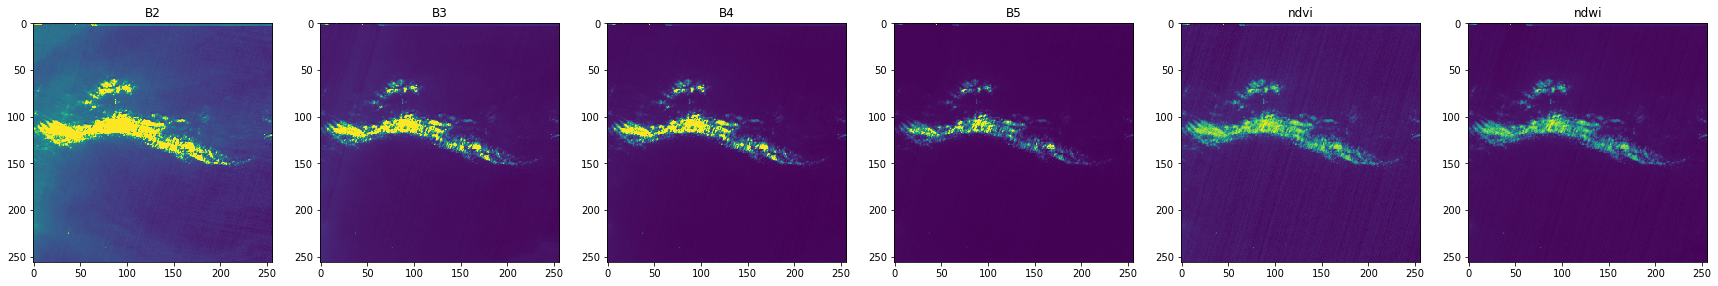

In [108]:
display_channels(input_arr, input_arr.shape[2], titles=bands[0])

### Generate predictions for the image pixels

To get predictions in each pixel, run the image dataset through the trained model using model.predict(). Print the first prediction to see that the output is a list of the three class probabilities for each pixel. Running all predictions might take a while.

In [109]:
predictions = model.predict(image_dataset, steps=PATCHES, verbose=1)

36/36 [==============================] - 168s 5s/step


In [111]:
output_arr = predictions.reshape((PATCHES, PATCH_WIDTH, PATCH_HEIGHT, len(bands[1])))
output_arr.shape

(36, 256, 256, 1)

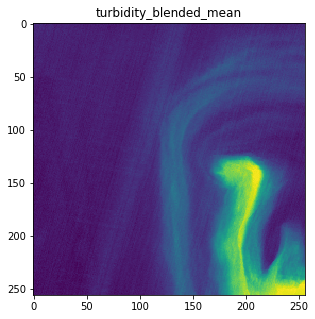

In [112]:
display_channels(output_arr[9,:,:,:], output_arr.shape[3], titles=bands[1])

### Write the predictions to a TFRecord file

We need to write the pixels into the file as patches in the same order they came out.  The records are written as serialized `tf.train.Example` protos. 

In [56]:
dataset_name = 'Sentinel2_WaterQuality'
bucket = env.bucket_name
folder = 'cnn-models/'+dataset_name+'/data'

output_file = 'gs://' + bucket + '/' + folder + '/predicted_image_pixel.TFRecord'
print('Writing to file ' + output_file)

Writing to file gs://skydipper_materials/cnn-models/Sentinel2_WaterQuality/data/predicted_image_pixel.TFRecord


In [57]:
# Instantiate the writer.
writer = tf.io.TFRecordWriter(output_file)

patch = [[]]
nPatch = 1
for prediction in predictions:
    patch[0].append(prediction[0][0])
    # Once we've seen a patches-worth of class_ids...
    if (len(patch[0]) == PATCH_WIDTH * PATCH_HEIGHT):
        print('Done with patch ' + str(nPatch) + ' of ' + str(PATCHES))
        # Create an example
        example = tf.train.Example(
            features=tf.train.Features(
              feature={
                'prediction': tf.train.Feature(
                    float_list=tf.train.FloatList(
                        value=patch[0]))
              }
            )
          )
        # Write the example to the file and clear our patch array so it's ready for
        # another batch of class ids
        writer.write(example.SerializeToString())
        patch = [[]]
        nPatch += 1

writer.close()

Done with patch 1 of 36
Done with patch 2 of 36
Done with patch 3 of 36
Done with patch 4 of 36
Done with patch 5 of 36
Done with patch 6 of 36
Done with patch 7 of 36
Done with patch 8 of 36
Done with patch 9 of 36
Done with patch 10 of 36
Done with patch 11 of 36
Done with patch 12 of 36
Done with patch 13 of 36
Done with patch 14 of 36
Done with patch 15 of 36
Done with patch 16 of 36
Done with patch 17 of 36
Done with patch 18 of 36
Done with patch 19 of 36
Done with patch 20 of 36
Done with patch 21 of 36
Done with patch 22 of 36
Done with patch 23 of 36
Done with patch 24 of 36
Done with patch 25 of 36
Done with patch 26 of 36
Done with patch 27 of 36
Done with patch 28 of 36
Done with patch 29 of 36
Done with patch 30 of 36
Done with patch 31 of 36
Done with patch 32 of 36
Done with patch 33 of 36
Done with patch 34 of 36
Done with patch 35 of 36
Done with patch 36 of 36


**Verify the existence of the predictions file**

In [58]:
!gsutil ls -l {output_file}

   9438912  2020-01-29T16:48:10Z  gs://skydipper_materials/cnn-models/Sentinel2_WaterQuality/data/predicted_image_pixel.TFRecord
TOTAL: 1 objects, 9438912 bytes (9 MiB)


### Upload the predicted image to an Earth Engine asset

In [59]:
asset_id = 'projects/vizzuality/skydipper-water-quality/predicted-image' 
print('Writing to ' + asset_id)

Writing to projects/vizzuality/skydipper-water-quality/predicted-image


In [60]:
# Start the upload.
!earthengine upload image --asset_id={asset_id} {output_file} {json_file}

Running command using Cloud API.  Set --no-use_cloud_api to go back to using the API

W0129 17:50:15.488069 140735877469056 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0 or google-auth
Traceback (most recent call last):
  File "/Users/ikersanchez/anaconda3/envs/py36tf115/lib/python3.6/site-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/ikersanchez/anaconda3/envs/py36tf115/lib/python3.6/site-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/

### View the predicted image

In [61]:
# Get centroid
polygon = ee.Geometry.Polygon(geometry.get('features')[0].get('geometry').get('coordinates'))

centroid = polygon.centroid().getInfo().get('coordinates')[::-1]

In [70]:
EE_TILES = 'https://earthengine.googleapis.com/map/{mapid}/{{z}}/{{x}}/{{y}}?token={token}'

map = folium.Map(location=centroid, zoom_start=8)
for n, collection in enumerate(collections):
    params = ee_collection_specifics.vizz_params(collection)[0]
    mapid = images[n].getMapId(params)
    folium.TileLayer(
        tiles=EE_TILES.format(**mapid),
        attr='Google Earth Engine',
        overlay=True,
        name=str(params['bands']),
      ).add_to(map)
        
        
# Read predicted Image
predicted_image = ee.Image(asset_id)
                           
mapid = predicted_image.getMapId({'bands': ['prediction'], 'min': 0, 'max': 1})
folium.TileLayer(
    tiles=EE_TILES.format(**mapid),
    attr='Google Earth Engine',
    overlay=True,
    name='predicted image',
  ).add_to(map)
                           
map.add_child(folium.LayerControl())
map